In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

**Defining the paths for dataset directories**

In [5]:
data_dir = r"/kaggle/input/gtsrb-german-traffic-sign"
train_dataset = r"/kaggle/input/gtsrb-german-traffic-sign/Train"
test_dataset = r"/kaggle/input/gtsrb-german-traffic-sign"

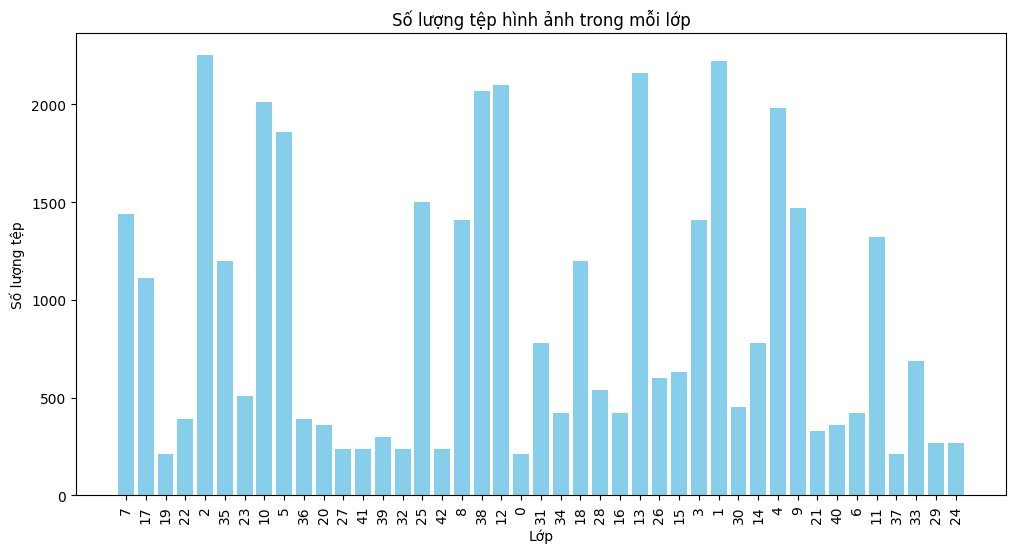

In [6]:
# Danh sách để lưu số lượng tệp trong mỗi lớp
file_counts = []

# Duyệt qua từng thư mục lớp trong train_dataset
for class_folder in os.listdir(train_dataset):
    class_path = os.path.join(train_dataset, class_folder)
    # Đếm số lượng tệp trong mỗi thư mục lớp
    num_files = len(os.listdir(class_path))
    file_counts.append(num_files)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.bar(range(len(file_counts)), file_counts, color='skyblue')
plt.xticks(range(len(file_counts)), os.listdir(train_dataset), rotation=90)  # Xoay nhãn trên trục x
plt.title('Số lượng tệp hình ảnh trong mỗi lớp')
plt.xlabel('Lớp')
plt.ylabel('Số lượng tệp')
plt.show()

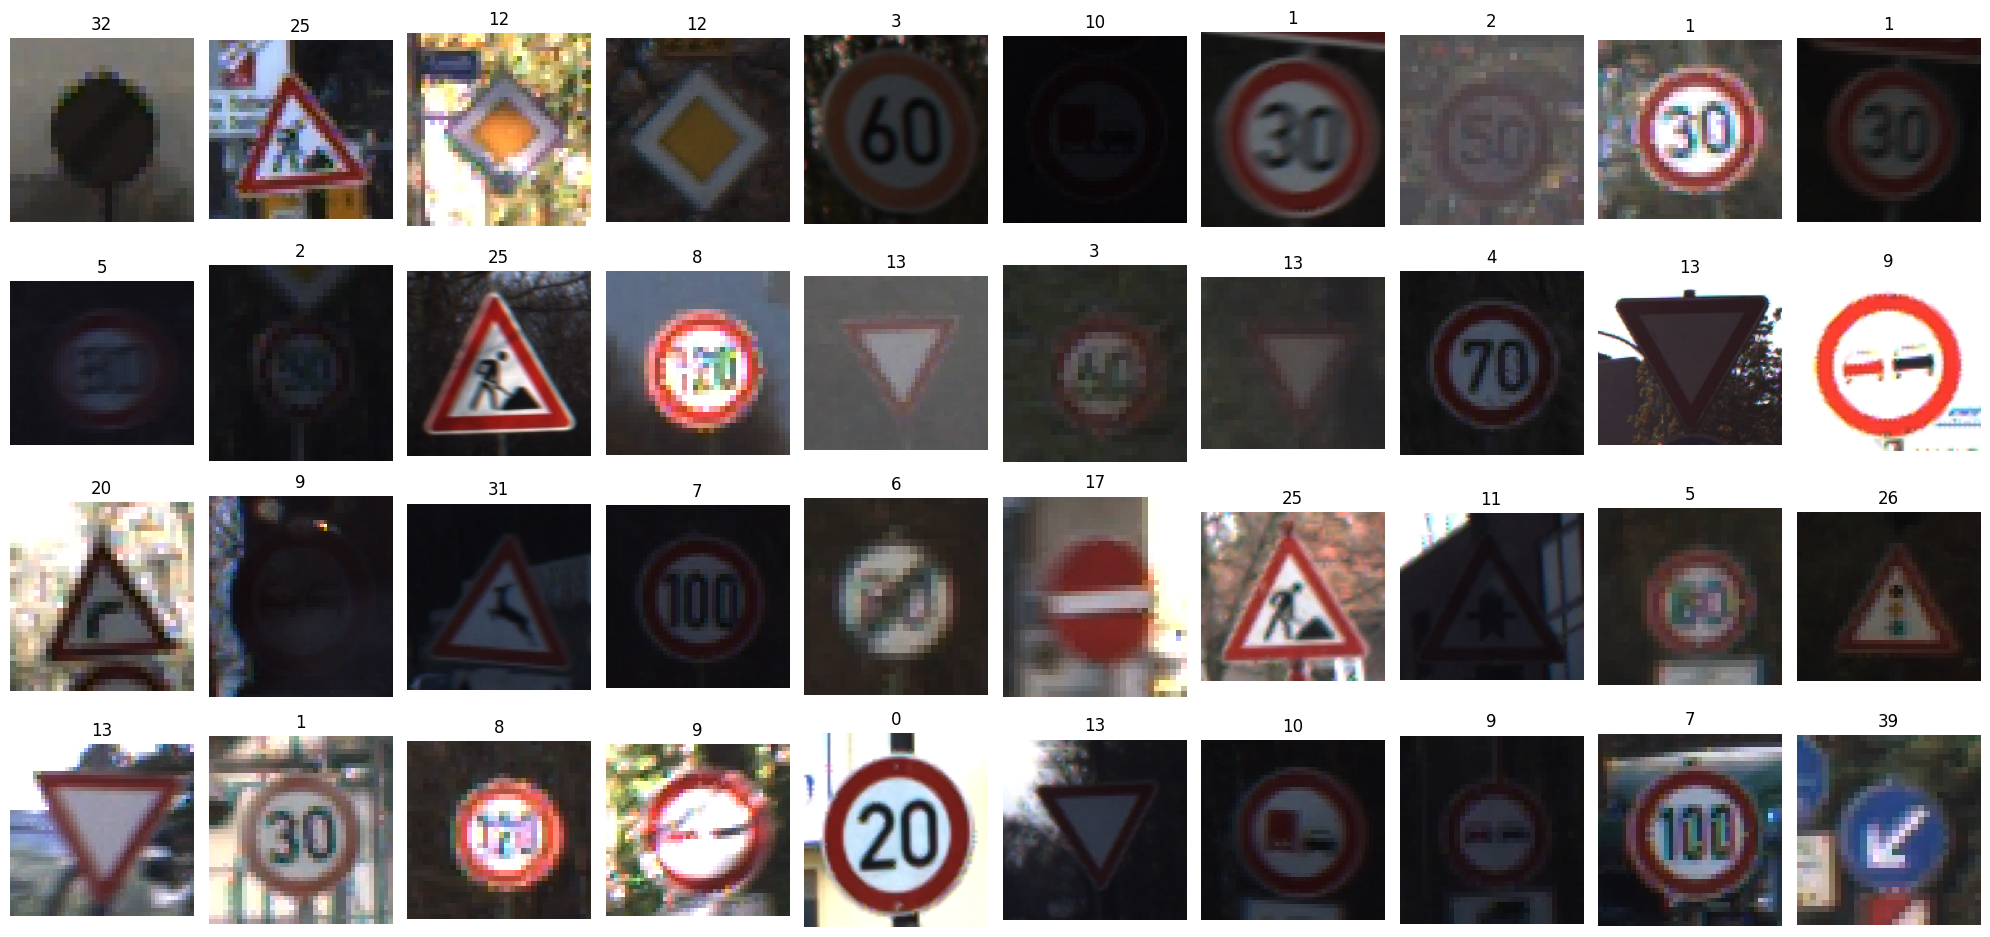

In [11]:
# Tạo danh sách chứa đường dẫn đến các tệp hình ảnh và nhãn của chúng
image_paths = []
labels = []

for class_folder in os.listdir(train_dataset):
    class_path = os.path.join(train_dataset, class_folder)
    for image_file in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, image_file))
        labels.append(class_folder)  # Nhãn là tên thư mục lớp

# Tạo DataFrame từ danh sách
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Chọn ngẫu nhiên số lượng hình ảnh để hiển thị
num_images_to_show = 40  # Bạn có thể thay đổi số lượng hình ảnh cần hiển thị
random_indices = np.random.choice(df.index, size=num_images_to_show, replace=False)
balanced_images = df.loc[random_indices]

# Hiển thị hình ảnh
fig, axes = plt.subplots(4, 10, figsize=(20, 10))
for i in range(4):
    for j in range(10):        
        image = cv2.imread(balanced_images.iloc[j + 10 * i]['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển đổi màu sắc từ BGR sang RGB
        axes[i, j].imshow(image)
        axes[i, j].set_title(balanced_images.iloc[j + 10 * i]['label'])  
        axes[i, j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Defining important constants like the input image size, batch size, and the number of categories (classes). The number of categories is calculated based on the number of folders in the training directory**

In [12]:
height = 30
width = 30
channels = 3
batch_size = 32
NUM_CATEGORIES = len(os.listdir(train_dataset))

**The function below reads images from the training directory, resizes them to 30x30, and stores both their image data and their corresponding labels.**

In [13]:
def load_data(data_dir):
    images = []
    labels = []
    for class_folder in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_folder)
        for image_file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, image_file))
            img = cv2.resize(img, (width, height))
            images.append(img)
            labels.append(int(class_folder))
    return np.array(images), np.array(labels)

**Using the load data function to load all training images and then shuffle them**

In [14]:
X_train, y_train = load_data(train_dataset)

X_train, y_train = shuffle(X_train, y_train, random_state=42)


**Using ImageDataGenerator to perform data augmentation. Transformations like rotation, shifts , and zooms will be used during training. Also, further splitting 20% of the data for validation**

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.2
)

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    subset='training'
)

validation_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    subset='validation'
)

**Defining the CNN with 3 convolutional layers. Dropout layer used to prevent overfitting, and the output layer uses *softmax* activation for multi-class classification**

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CATEGORIES, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,715 (487.17 KB)

 Trainable params: 124,715 (487.17 KB)

 Non-trainable params: 0 (0.00 B)

**Compiling the model using *Adam* optimiser and categorical cross-entropy loss, which is suitable for multi-class classification**

In [18]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**Training the model for 30 epochs and using early stopping to monitor validation loss and stop training when performance doesnt improve**

In [19]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/30


I0000 00:00:1729155329.463043     152 service.cc:145] XLA service 0x79ffc4004ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729155329.463110     152 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  8/981 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.0248 - loss: 3.7589

I0000 00:00:1729155332.960963     152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


981/981 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - accuracy: 0.1669 - loss: 3.1037 - val_accuracy: 0.5319 - val_loss: 1.4646
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.4765 - loss: 1.6041 - val_accuracy: 0.6877 - val_loss: 0.9688
Epoch 3/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.5962 - loss: 1.1977 - val_accuracy: 0.8061 - val_loss: 0.6152
Epoch 4/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - accuracy: 0.6933 - loss: 0.9093 - val_accuracy: 0.8643 - val_loss: 0.4378
Epoch 5/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.7516 - loss: 0.7358 - val_accuracy: 0.8938 - val_loss: 0.3661
Epoch 6/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.7942 - loss: 0.6140 - val_accuracy: 0.9240 - val_loss: 0.3005
Epoch 7/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.8250 - loss: 0.5233 - val_accuracy: 0.9383 - val_loss: 0.2223
Epoch 8/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - accuracy: 0.8461 - loss: 0.4570 - val_accurac

In [20]:
training_accuracy = history.history["accuracy"]
training_loss = history.history["loss"]
validation_accuracy = history.history["val_accuracy"]
validation_loss = history.history["val_loss"]

**Plotting the metrics to visualise model performance**

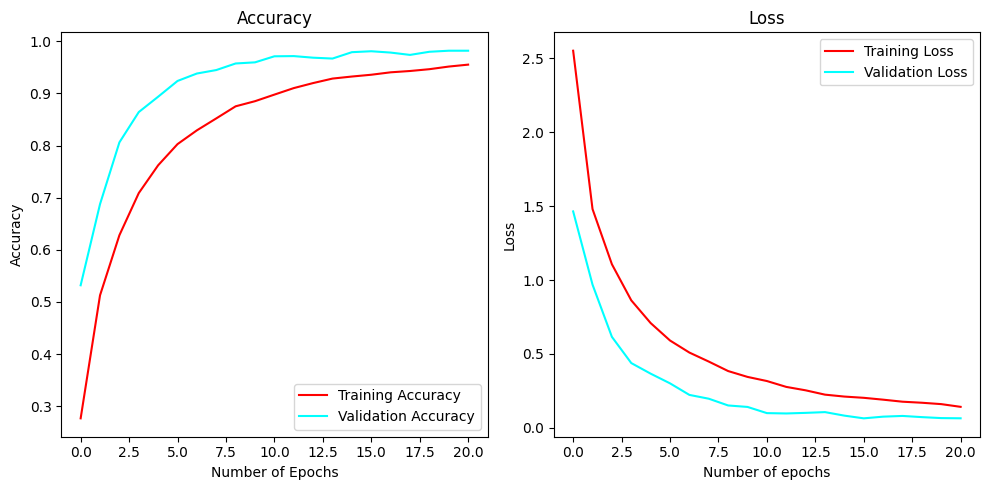

In [21]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(training_accuracy, color = "red", label = "Training Accuracy")
plt.plot(validation_accuracy, color = "cyan", label = "Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(training_loss, color = "red", label = "Training Loss")
plt.plot(validation_loss, color = "cyan", label = "Validation Loss")
plt.legend()
plt.title("Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

**Loading and preprocessing the test data**

In [22]:
test_csv_path = r'/kaggle/input/gtsrb-german-traffic-sign/Test.csv'
test_df = pd.read_csv(test_csv_path)
test_df.columns = ["Width", "Height", "Roi.X1", "Roi.Y1", "Roi.X2", "Roi.Y2", "ClassId", "Path"]
test_df['Path'] = test_df['Path'].apply(lambda x: os.path.join(test_dataset, x.strip()))

def load_test_data(test_df):
    images = []
    for path in test_df['Path']:
        img = cv2.imread(path)
        img = cv2.resize(img, (width, height))
        images.append(img)
    return np.array(images)

X_test = load_test_data(test_df)
X_test = X_test / 255.0

**Predicting on the test dataset and computing the accuracy**

In [23]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_df["ClassId"].values

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test accuracy: {accuracy * 100:.4f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test accuracy: 95.1702%


**Plotting the confusion matrix**

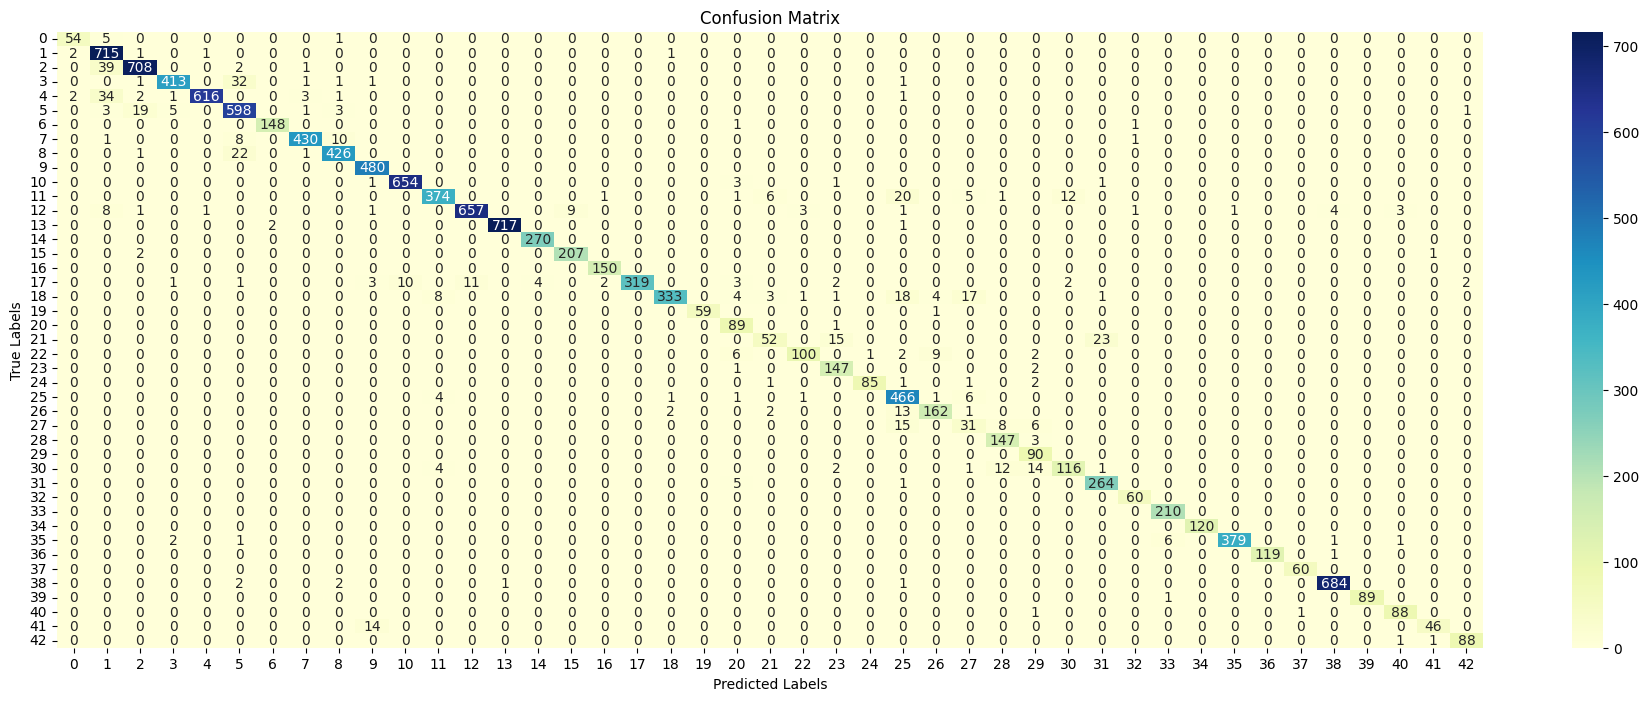

In [24]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(23, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=range(NUM_CATEGORIES), yticklabels=range(NUM_CATEGORIES))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
model.save('my_model.h5')